# Vehicle Detection and Tracking
**In this project, I built a software pipeline to detect vehicles in a video.**

## Pipeline architecture:
- **Compute Camera Calibration.**
- **Apply Distortion Correction**.
- **Apply a Perspective Transform.**
- **Create a Thresholded Binary Image.**
- **Define the Image Processing Pipeline.**
- **Detect Lane Lines.**
- **Determine the Curvature of the Lane and Vehicle Position.**
- **Visual display of the Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position.**
- **Process Project Videos.**

I'll explain each step in details below.

#### Environement:
-  Ubuntu 16.04
-  Anaconda 5.0.1
-  Python 3.6.2
-  OpenCV 3.1.0

In [1]:
# Importing Python libraries
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from ipywidgets import interact, interactive, fixed
from IPython.display import HTML

In [2]:
def display(images, labels, x, y, n=2, cmap=None):
    """
    Diplay the input images side-by-side.
        Parameters:
            images: List of images to be displayed.
            labels: List of labels.
            x, y: Figure size.
            n (Default = 2) = Number of images to be displayed.
            cmap (Default = None): Used to display gray images.
    """
    count = 1
    plt.figure(figsize=(x, y))
    for img, lbl in zip(images, labels):
        plt.subplot(1, n, count)
        plt.imshow(img, cmap = cmap)
        plt.xlabel(lbl, fontsize=12)
        plt.xticks([])
        plt.yticks([])
        count += 1
    plt.show()

---
## Step 1: Data Loading and Visualization

In [3]:
vehicle = []
for file in glob.glob('training_set/vehicles/**/*.png'):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    vehicle.append(image)
    
nonvehicle = []
for file in glob.glob('training_set/non-vehicles/**/*.png'):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    nonvehicle.append(image)

print("Vehicle Images:", len(vehicle))
print("Non-Vehicle Images:", len(nonvehicle))

Vehicle Images: 8792
Non-Vehicle Images: 8968


Vehicle examples:


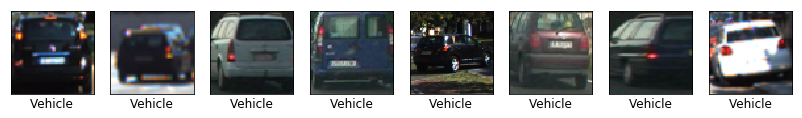

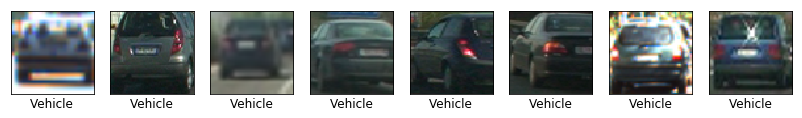

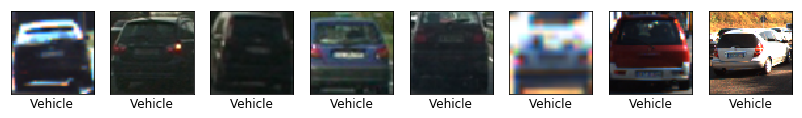

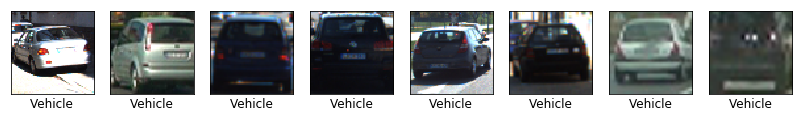

Non-Vehicle examples:


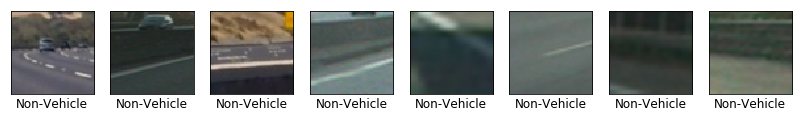

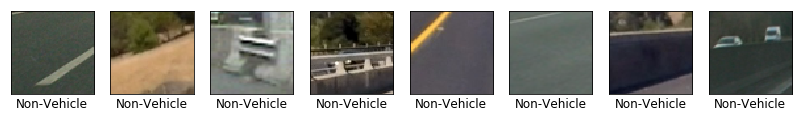

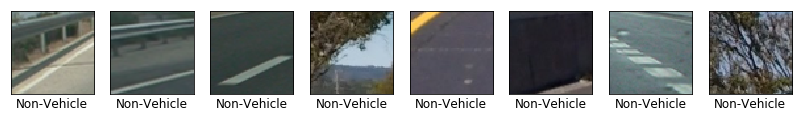

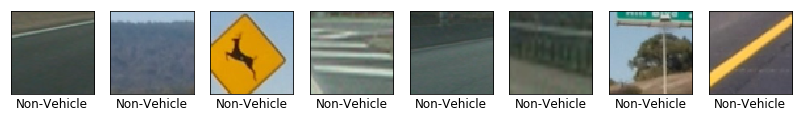

In [5]:
vehicle_examples = []
vehicle_labels = []
nonvehicle_examples = []
nonvehicle_labels = []

for i in np.arange(32):
    vehicle_examples.append(vehicle[np.random.randint(0, len(vehicle))])
    vehicle_labels.append("Vehicle")
    nonvehicle_examples.append(nonvehicle[np.random.randint(0, len(nonvehicle))])
    nonvehicle_labels.append("Non-Vehicle")

print("Vehicle examples:")
x = 0
y = 8
while(x != 32):
    display(vehicle_examples[x:y], vehicle_labels, 14, 7, 8)
    y += 8
    x += 8

print("Non-Vehicle examples:")
x = 0
y = 8
while(x != 32):
    display(nonvehicle_examples[x:y], nonvehicle_labels, 14, 7, 8)
    y += 8
    x += 8

---
## Step 2: Features Extraction

After loading the training set in the previous step, we will now extract the images' features. We'll extract three types of features:
- [Histogram of Oriented Gradients (HOG)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients): Shape features.
- Binned color: Color and shape features.
- Color histogram features: Color only features.

In [25]:
def hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract the HOG features from the input image.
        Parameters:
            img: Input image.
            orient: Number of orientation bins.
            pix_per_cell: Size (in pixels) of a cell.
            cell_per_block: Number of cells in each block.
            vis: Visualization flag.
            feature_vec: Return the data as a feature vector.
    """
    features, hog_image = hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualise=True, feature_vector=feature_vec)
    if vis == True:
        return features, hog_image
    else:
        return features

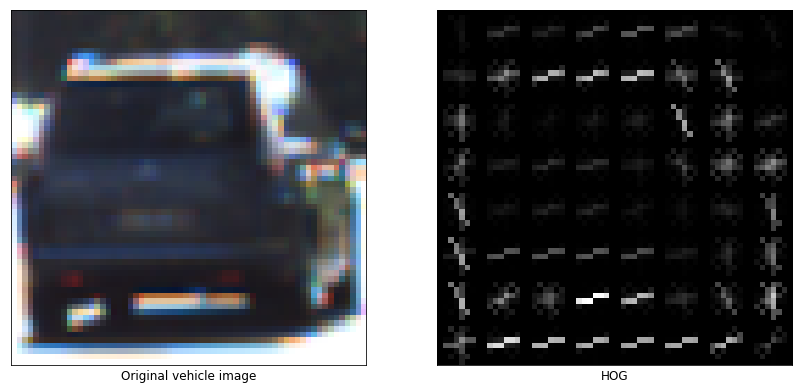

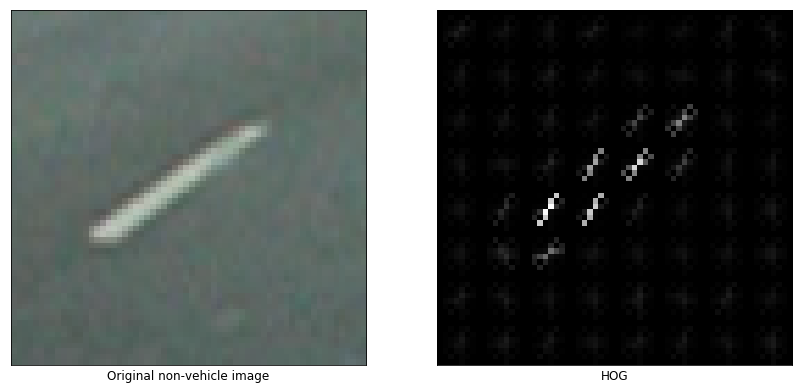

In [13]:
veh_img = vehicle[np.random.randint(0, len(vehicle))]
_, veh_dst = hog_features(veh_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
nonveh_img = nonvehicle[np.random.randint(0, len(nonvehicle))]
_, nonveh_dst = hog_features(nonveh_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

display((veh_img, veh_dst), ("Original vehicle image", "HOG"), 14, 7, 2, "gray")
display((nonveh_img, nonveh_dst), ("Original non-vehicle image", "HOG"), 14, 7, 2, "gray")

In [31]:
def bin_spatial(img, size=(16, 16)):
    """
    Compute the binned color features of the input image.
        Parameters:
            img: Input image.
            size (Default = 16 x 16): 
    """
    return cv2.resize(img, size).ravel() 

In [32]:
def color_hist(img, nbins=32):
    """
    Compute the color histogram features of the input image.
        Parameters:
            img: Input image.
            nbins (Default = 32): Number of histogram pins.
    """
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

In [33]:
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, color_space='RGB'):
    """
    Extract the features from the input image.
        Parameters:
            feature_image: Input image (RGB).
            spatial_feat: Binned color features flag.
            hist_feat: Color histogram features flag
            hog_feat: HOG features flag.
            hist_bins: Number of histogram pins.
            orient: Number of orientation bins.
            pix_per_cell: Size (in pixels) of a cell.
            cell_per_block: Number of cells in each block.
            vis: Visualization flag.
            feature_vec: Return the data as a feature vector.
            hog_channel: Number of channels per cell.
            color_space (Default = RGB): Selected color space.
    """
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features_list = []
            for channel in range(feature_image.shape[2]):
                hog_features_list.append(hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features_list = np.ravel(hog_features_list)        
        else:
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_LUV2RGB)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_HLS2RGB)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_YUV2RGB)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features_list = hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features_list)
    return file_features

In [34]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract the features from the input images and ugment the dataset with flipped images.
        Parameters:
            imgs: Input images.
            color_space (Default = RGB): Selected color space.
            spatial_size (Default = (32, 32)): Spatial binning dimensions.
            hist_bins (Default = 32):  Number of histogram pins.
            orient (Default = 9): Number of orientation bins.
            pix_per_cell (Default = 8): Size (in pixels) of a cell.
            cell_per_block (Default = 2): Number of cells in each block.
            hog_channel (Default = 0): Number of channels per cell.
            spatial_feat: Binned color features flag.
            hist_feat: Color histogram features flag
            hog_feat: HOG features flag.
    """
    features = []
    for image in imgs:
        file_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)     
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, color_space)
        features.append(np.concatenate(file_features))
        feature_image = cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, color_space)
        features.append(np.concatenate(file_features))
    return features

In [38]:
# Define parameters for feature extraction
color_space = 'RGB'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8              # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel = 0         # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32          # Number of histogram bins
spatial_feat = True     # Spatial features flag
hist_feat = True        # Histogram features flag
hog_feat = True         # HOG features flag

In [39]:
t = time.time()
vehicle_features = extract_features(vehicle, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nonvehicle_features = extract_features(nonvehicle, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()

print ('Vehicle samples:', len(vehicle_features))
print ('Non-Vehicle samples:', len(vehicle_features))
print('Feature extraction time:', round((round(t2 - t, 2)/60), 2), 'minutes')

Vehicle samples: 17584
Non-Vehicle samples: 17584
Feature extraction time: 8.02 minutes


---
## Step 3: Classification

After extracting the images' features, we will now train a Linear Support Victor Clustering (LinearSVC) algorithm to classify the images to "vehicle" and "non-vehicle".

In [40]:
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)   

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

# Split up data into randomized training and test sets (20% for testing)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(loss='hinge')

# Train the classifier
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print('SVC training time:', round(t2 - t, 2), 'seconds')
print('Test Accuracy of SVC =', round(svc.score(X_test, y_test), 4)*100,'%') # Check the score of the SVC

Feature vector length: 2432
SVC training time: 15.08 seconds
Test Accuracy of SVC = 98.85 %
